# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Motivation

Used dataset: [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection/data) (About 1GB of data, with over 500k transactions.)

Problem: Predict which transactions are fraud.

# Import Data

The data is divided into five tables:
*   train_identity.csv
*   train_transaction.csv (information about the transcations)
*   test_transaction.csv
*   test_identity.csv
*   sample_submission.csv




In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime

warnings.filterwarnings('ignore')

In [3]:
%%time
# Transaction CSVs
train_transaction = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_transaction.csv')
test_transaction = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_transaction.csv')

# Identity CSVs - These will be merged onto the transactions to create additional features
train_identity = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_identity.csv')
test_identity = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_identity.csv')

# Sample Submissions
sample_submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sample_submission.csv')

CPU times: user 43.2 s, sys: 4.92 s, total: 48.1 s
Wall time: 52.8 s


In [4]:
print(f'train_transaction has {train_transaction.shape[0]} rows and {train_transaction.shape[1]} columns.')
print(f'test_transaction has {test_transaction.shape[0]} rows and {test_transaction.shape[1]} columns.')
print(f'train_identity has {train_identity.shape[0]} rows and {train_identity.shape[1]} columns.')
print(f'test_identity has {test_identity.shape[0]} rows and {test_identity.shape[1]} columns.')

train_transaction has 590540 rows and 394 columns.
test_transaction has 506691 rows and 393 columns.
train_identity has 144233 rows and 41 columns.
test_identity has 141907 rows and 41 columns.


In [5]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


Merging transactions with identity in order to work with the entire set

In [0]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

# Data Understanding

Information about train_transaction

In [8]:
train_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [9]:
train_transaction.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

Information about train_identity



In [10]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
TransactionID    144233 non-null int64
id_01            144233 non-null float64
id_02            140872 non-null float64
id_03            66324 non-null float64
id_04            66324 non-null float64
id_05            136865 non-null float64
id_06            136865 non-null float64
id_07            5155 non-null float64
id_08            5155 non-null float64
id_09            74926 non-null float64
id_10            74926 non-null float64
id_11            140978 non-null float64
id_12            144233 non-null object
id_13            127320 non-null float64
id_14            80044 non-null float64
id_15            140985 non-null object
id_16            129340 non-null object
id_17            139369 non-null float64
id_18            45113 non-null float64
id_19            139318 non-null float64
id_20            139261 non-null float64
id_21            5159 non-null float64
id_2

Number of columns with missing values?

In [11]:
print(f'There are {train_transaction.isnull().any().sum()} columns in train dataset with missing values.')

There are 374 columns in train dataset with missing values.


Average transaction amount for fraudulent and non fraudulent transactions

In [12]:
print('Mean transaction amount for fraud is {:.4f}'.format(train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].mean()))
print('Mean transaction amount for non-fraud is {:.4f}'.format(train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].mean()))

Mean transaction amount for fraud is 149.2448
Mean transaction amount for non-fraud is 134.5117


How is the TransactionDT distributed?

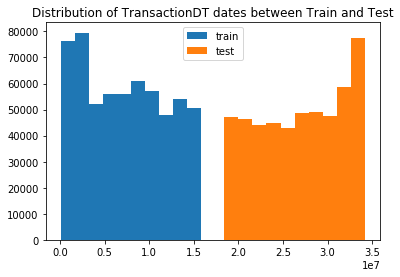

In [13]:
plt.hist(train_transaction['TransactionDT'], label='train');
plt.hist(test_transaction['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution of TransactionDT dates between Train and Test');

It appears that the train and test sets, where split by time

How many fraud and non fraud records?

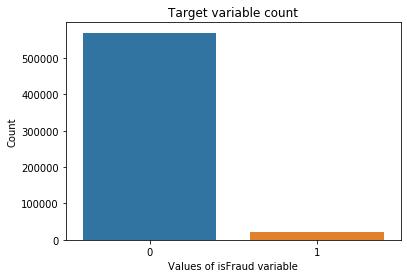

In [14]:
# Checking for data imbalance

x = train_transaction['isFraud'].value_counts().values
sns.barplot([0,1],x)
plt.xlabel("Values of isFraud variable")
plt.ylabel("Count")
plt.title('Target variable count');

Here we can see that the data is imbalanced

In [15]:
print('In train {:.4f}% of transactions are fraud.'.format(train_transaction['isFraud'].mean() * 100))

In train 3.4990% of transactions are fraud.


# Data Exploration

## Exploration of TransactionAMT

The transaction amount follows a log-normal distribuition, and 
most transactions are made with small amounts of cash

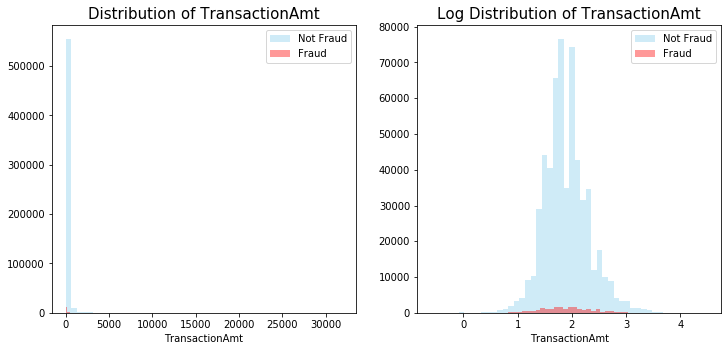

In [16]:
plt.figure(figsize=(12,18))

plt.subplot(321)
sns.distplot(train[train['isFraud'] == 0]['TransactionAmt'], color = 'skyblue', kde= False, label = 'Not Fraud')
sns.distplot(train[train['isFraud'] == 1]['TransactionAmt'], color = 'red', kde= False , label = 'Fraud')
plt.title('Distribution of TransactionAmt', fontsize = 15)
plt.legend()

plt.subplot(322)
sns.distplot(np.log10(train[train['isFraud'] == 0]['TransactionAmt']), color = 'skyblue', kde= False, label = 'Not Fraud')
sns.distplot(np.log10(train[train['isFraud'] == 1]['TransactionAmt']), color = 'red', kde= False , label = 'Fraud')
plt.title('Log Distribution of TransactionAmt', fontsize = 15)
plt.legend()

## Exploration of ProductCD

Which products are most associated with fraud transactions?

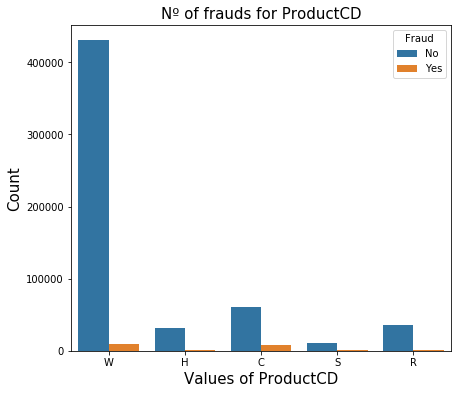

In [17]:
plt.figure(figsize=(15,6))

total = len(train)

plt.subplot(122)
g = sns.countplot(x='ProductCD', hue='isFraud', data=train)
g.set_title('Nº of frauds for ProductCD', fontsize = 15)
g.set_xlabel("Values of ProductCD", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

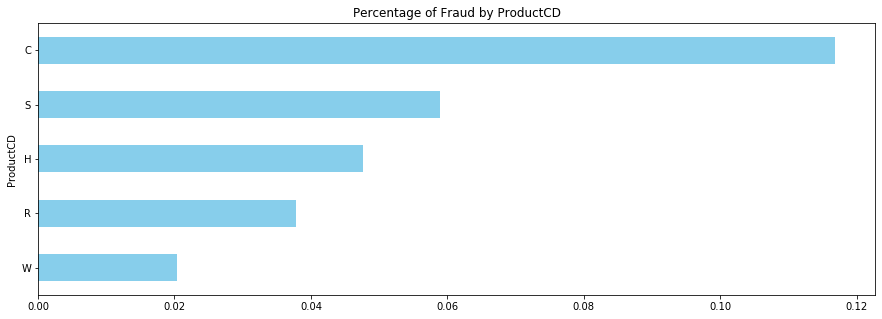

In [18]:
train.groupby('ProductCD') \
    .mean()['isFraud'] \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 5),
          title='Percentage of Fraud by ProductCD', color = 'skyblue')
plt.show()

## Exploration of card1 to card6

In [19]:
train.describe().loc[:,'card1':'card5']

,card1,card2,card3,card5
count,590540.000000,581607.000000,588975.000000,586281.000000
mean,9898.734658,362.555488,153.194925,199.278897
std,4901.170153,157.793246,11.336444,41.244453
min,1000.000000,100.000000,100.000000,100.000000
25%,6019.000000,214.000000,150.000000,166.000000
50%,9678.000000,361.000000,150.000000,226.000000
75%,14184.000000,512.000000,150.000000,226.000000
max,18396.000000,600.000000,231.000000,237.000000


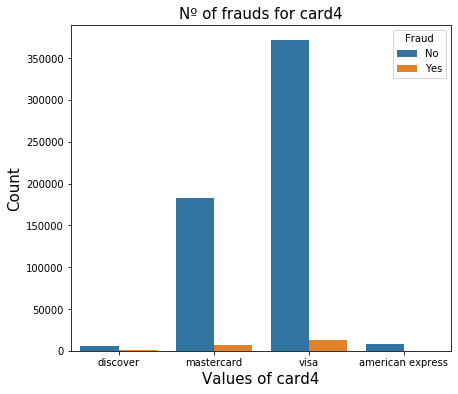

In [20]:
plt.figure(figsize=(15,6))

total = len(train)

plt.subplot(122)
g = sns.countplot(x='card4', hue='isFraud', data=train)
g.set_title('Nº of frauds for card4', fontsize = 15)
g.set_xlabel("Values of card4", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

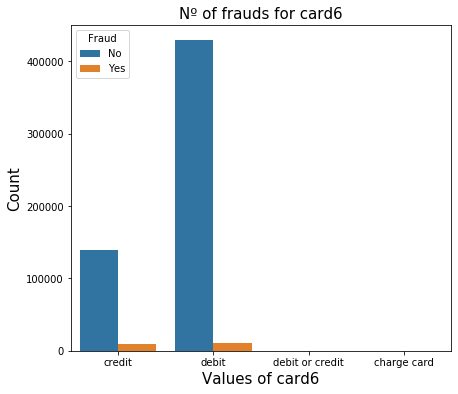

In [21]:
plt.figure(figsize=(15,6))

total = len(train)

plt.subplot(122)
g1 = sns.countplot(x='card6', hue='isFraud', data=train)
g1.set_title('Nº of frauds for card6', fontsize = 15)
g1.set_xlabel("Values of card6", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

Most transactions are made with a debit card, but the percentage of frauds is higher for credit cards

## Exploration of email domain

What is the most used email by the purchaser?

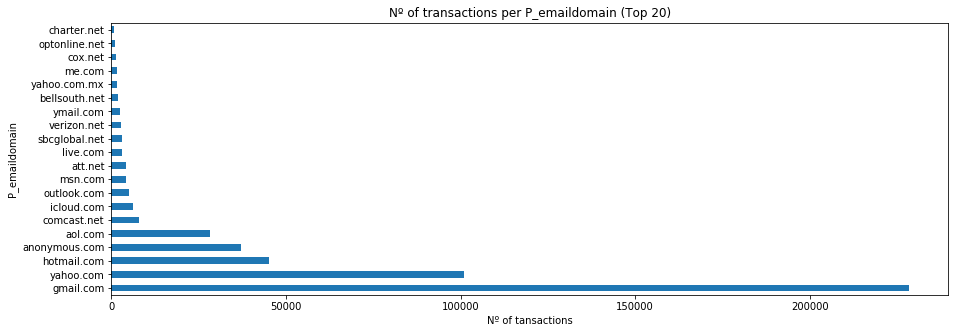

In [22]:
train.groupby('P_emaildomain') \
    .count()['TransactionID'] \
    .sort_values(ascending=False) \
    .head(20) \
    .plot(kind='barh', figsize=(15, 5), title='Nº of transactions per P_emaildomain (Top 20)')
plt.xlabel('Nº of tansactions')
plt.show()

What is the most used email by the recipient?

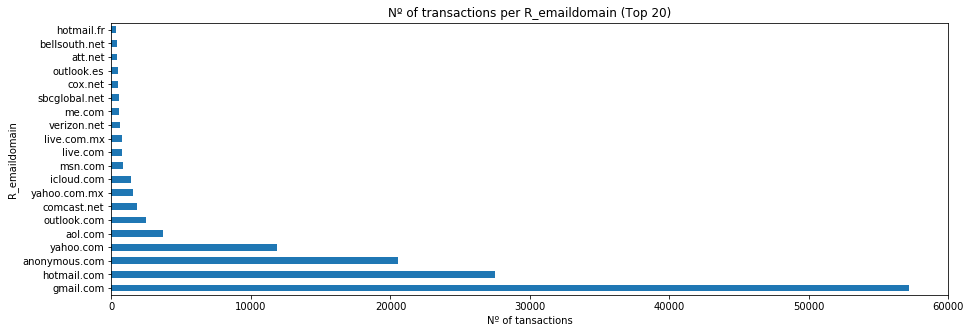

In [23]:
train.groupby('R_emaildomain') \
    .count()['TransactionID'] \
    .sort_values(ascending=False) \
    .head(20) \
    .plot(kind='barh', figsize=(15, 5), title='Nº of transactions per R_emaildomain (Top 20)')
plt.xlabel('Nº of tansactions')
plt.show()

## Exploration of DeviceType

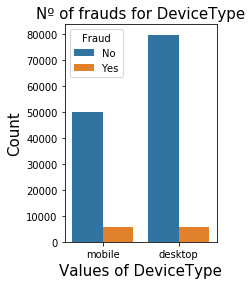

In [24]:
plt.subplot(122)
g1 = sns.countplot(x='DeviceType', hue='isFraud', data=train)
g1.set_title('Nº of frauds for DeviceType', fontsize = 15)
g1.set_xlabel("Values of DeviceType", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

More transactions are made in desktop

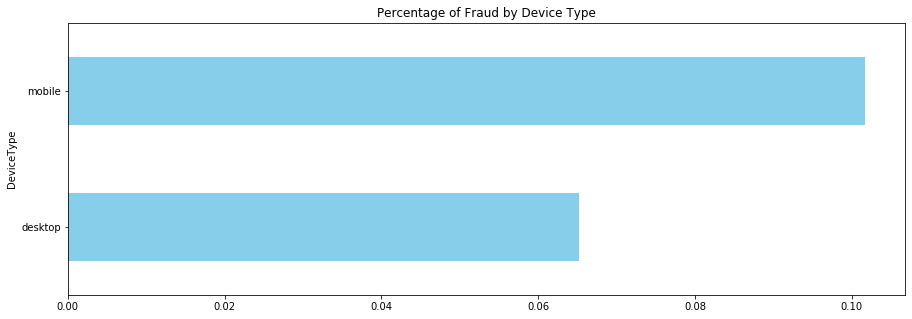

In [25]:
train.groupby('DeviceType') \
    .mean()['isFraud'] \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 5),
          title='Percentage of Fraud by Device Type', color = 'skyblue')
plt.show()

But the percentage of fraud for mobile is higher

## Exploration of DeviceInfo

What is the most used device for making transactions?

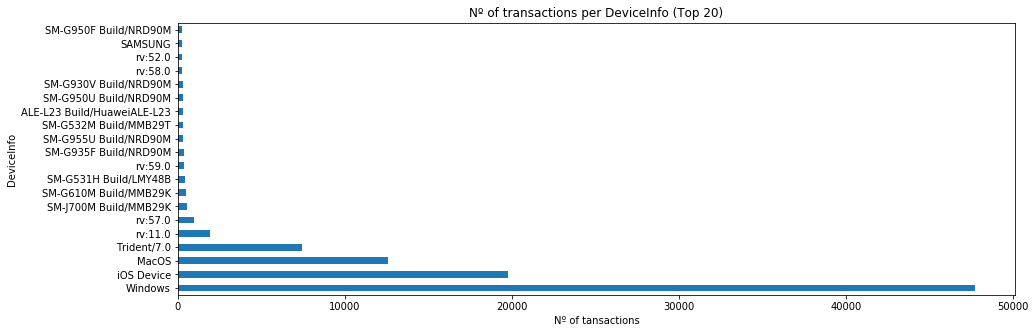

In [26]:
train.groupby('DeviceInfo') \
    .count()['TransactionID'] \
    .sort_values(ascending=False) \
    .head(20) \
    .plot(kind='barh', figsize=(15, 5), title='Nº of transactions per DeviceInfo (Top 20)')
plt.xlabel('Nº of tansactions')
plt.show()


# Feature Engineering

Create aggregation variables based on the transaction amount for:
*   Card1, Card2, Card3, Card4, Card5 and Card6








In [0]:
cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

for col in cols:
  aggr = train[train['TransactionAmt'] != np.nan].groupby([col])['TransactionAmt']
  train[str(col) + '_TransactionAmt_mean'] = train['TransactionAmt'] / aggr.transform('mean')
  train[str(col) + '_TransactionAmt_std'] = train['TransactionAmt'] / aggr.transform('std')

From TransactionDT create the following features:
*   Hour (0 to 23)
*   Day of week (0 to 6)
*   Day (1 to 31)

In [0]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

train['TransactionDT'] = train['TransactionDT'].fillna(train['TransactionDT'].median())
temp_df = train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
train['DT_hour'] = temp_df.dt.hour
train['DT_dayOfWeek'] = temp_df.dt.dayofweek
train['DT_day'] = temp_df.dt.day


# Data Preparation

In [0]:
# Cleaning unnecessary variables

del train_transaction, train_identity, test_transaction, test_identity

In [30]:
# Removing unnecessary features

useless_features = train.filter(like='V').columns
train = train.drop(useless_features, axis=1)

print('Deleted {} useless feature.'.format(len(useless_features)))

Deleted 339 useless feature.


Replace unknown values with a constant,the value -999, is to interfere less with the models


In [0]:
train = train.fillna(-999)
train.replace(np.inf, -999, inplace=True)

Label encoding

In [0]:
from sklearn.preprocessing import LabelEncoder

for f in train.columns:
    if train[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values))
        train[f] = lbl.transform(list(train[f].values))

Applying undersample to our majority class, this is for tackling the data imbalance


In [0]:
from sklearn.utils import resample

fraud = train[train['isFraud'] == 1]
not_fraud = train[train['isFraud'] == 0]

not_fraud_downsampled = resample(not_fraud,
                                 replace = False, 
                                 n_samples = len(fraud),
                                 random_state = 27) 

# combine minority and downsampled majority
train = pd.concat([not_fraud_downsampled, fraud])

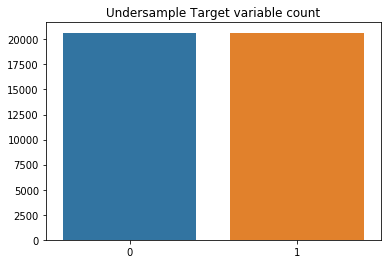

In [34]:
x = train['isFraud'].value_counts().values
sns.barplot([0,1], x)
plt.title('Undersample Target variable count');

# Modeling


In [0]:
y_train = train['isFraud'].copy()

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train.drop('isFraud', axis=1), 
                                                    y_train, 
                                                    test_size=.2,
                                                    random_state=1)

In [0]:
scores = {}
result_roc = {}

## Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

In [39]:
%%time

clf.fit(X_train, y_train)

CPU times: user 2.19 s, sys: 9.7 ms, total: 2.2 s
Wall time: 2.2 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_preds = clf.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_preds)

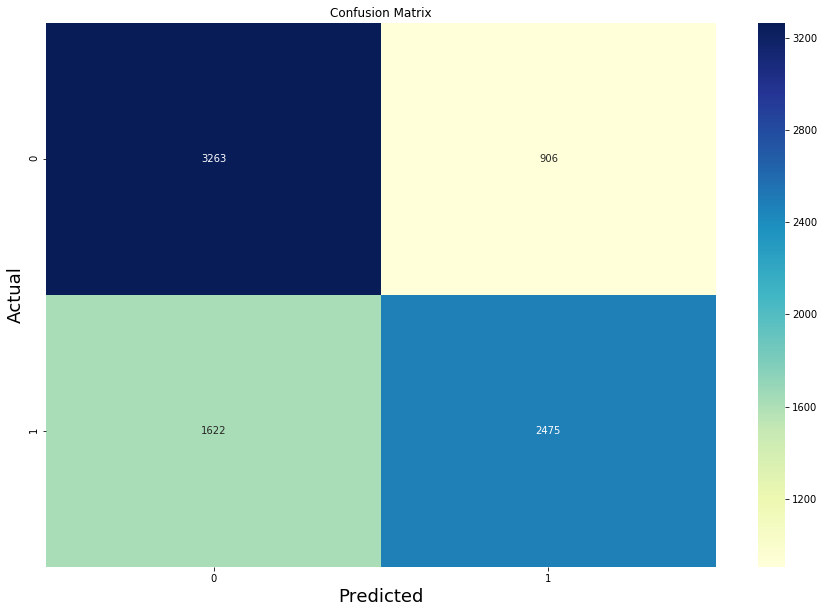

In [42]:
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True,  fmt="d", cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.show()

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_preds)
f1score = f1_score(y_test, y_preds, average='weighted', pos_label='1')
precision = precision_score(y_test, y_preds, average='weighted', pos_label='1')
recall= recall_score(y_test, y_preds, average='weighted', pos_label='1')

print("Accuracy: ", accuracy)
print("F1 Score: ", f1score)
print("Precision: ", precision)
print("Recall: ", recall)

Accuracy:  0.6941688845874667
F1 Score:  0.6916203240301444
Precision:  0.6997185161074696
Recall:  0.6941688845874667


In [0]:
y_proba = clf.predict_proba(X_test)[:,1]

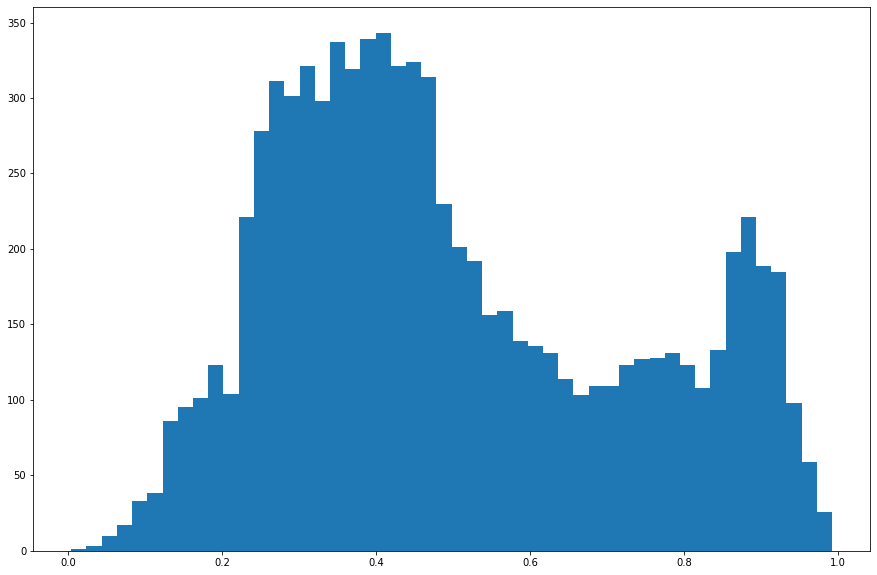

In [45]:
plt.figure(figsize=(15, 10))
plt.hist(y_proba, bins=50);

In [46]:
from sklearn.metrics import mean_squared_error 

mse = mean_squared_error(y_test, y_proba) 
mse

0.1991925440105501

In [47]:
n_frauds  = len(y_proba[y_proba > 0.90])

print('Predicted {} frauds.'.format(n_frauds))

Predicted 492 frauds.


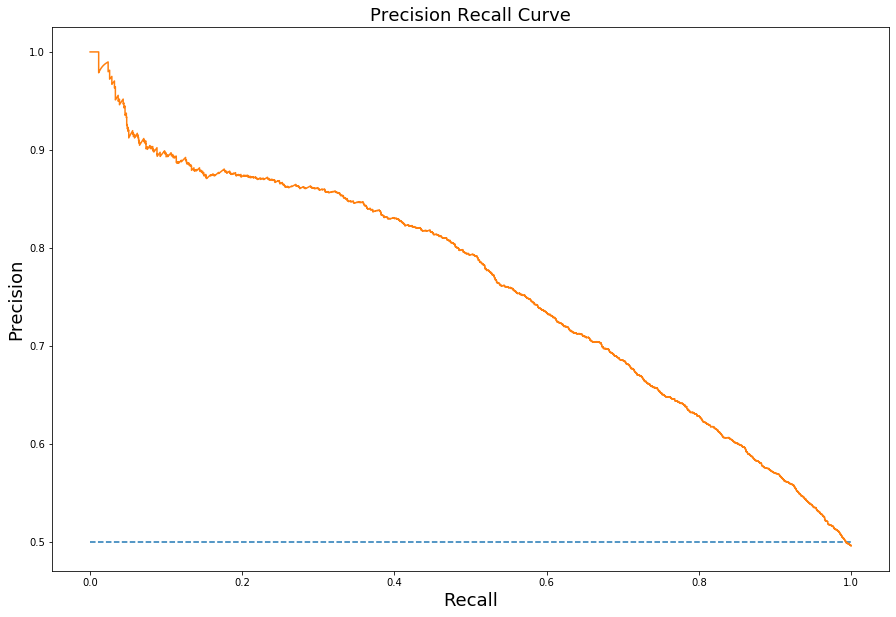

In [48]:
from sklearn import metrics

precision_c, recall_c, thresholds = metrics.precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(15, 10))
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall_c, precision_c)
plt.title("Precision Recall Curve", fontsize=18)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

plt.show()

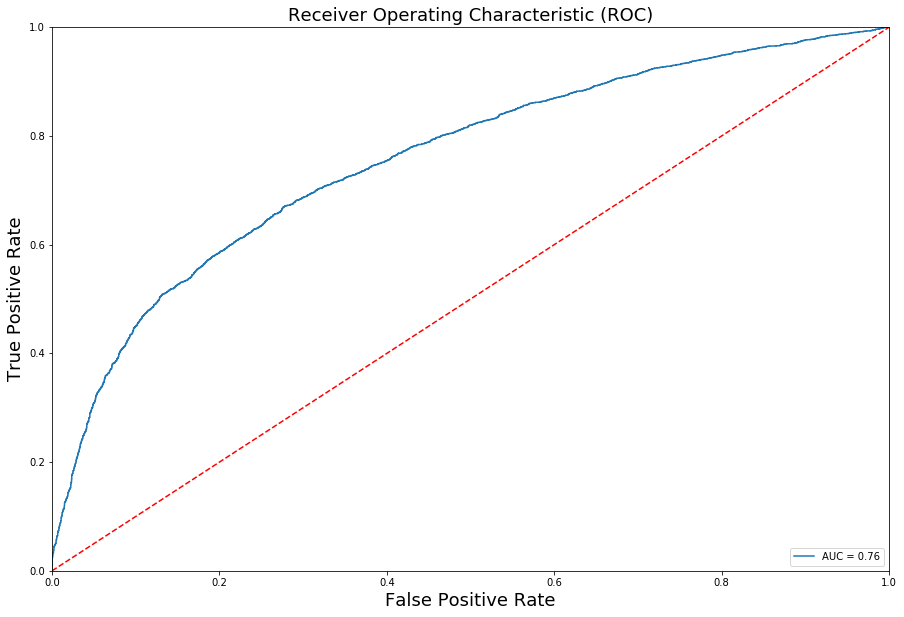

In [49]:
from sklearn import metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(15, 10))
plt.title('Receiver Operating Characteristic (ROC)', fontsize=18)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.show();

In [0]:
scores['LogisticRegression'] = [accuracy, f1score, precision, recall, mse, n_frauds]

result_roc['LogisticRegression'] = [fpr, tpr, roc_auc]

## Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500, max_depth=9, random_state=0)

In [52]:
%%time

clf.fit(X_train, y_train)

CPU times: user 26.3 s, sys: 40.9 ms, total: 26.4 s
Wall time: 26.4 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
y_preds = clf.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_preds)

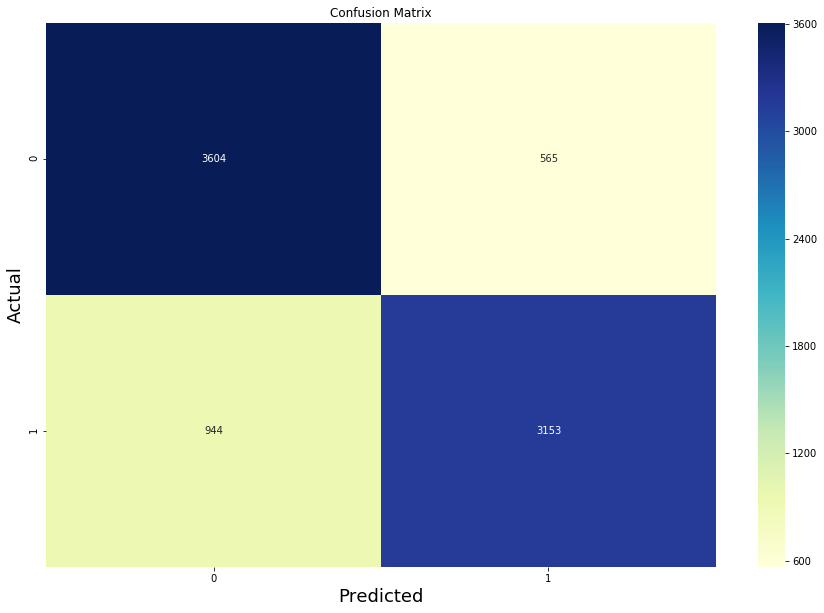

In [55]:
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True,  fmt="d", cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.show()

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_preds)
f1score = f1_score(y_test, y_preds, average='weighted', pos_label='1')
precision = precision_score(y_test, y_preds, average='weighted', pos_label='1')
recall= recall_score(y_test, y_preds, average='weighted', pos_label='1')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

Accuracy:  0.8174449552383257
Precision:  0.8199942572022827
Recall:  0.8174449552383257


In [0]:
y_proba = clf.predict_proba(X_test)[:,1]

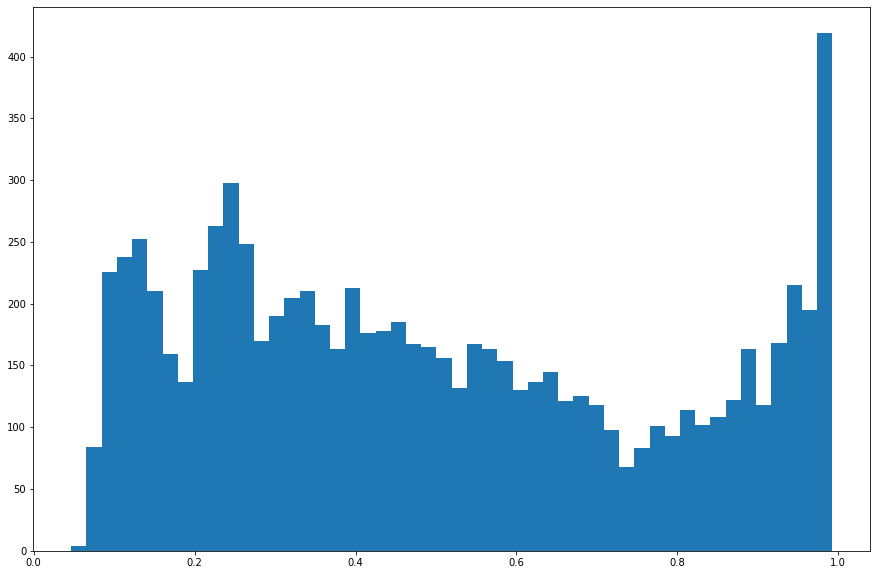

In [58]:
plt.figure(figsize=(15, 10))
plt.hist(y_proba, bins=50);

In [59]:
from sklearn.metrics import mean_squared_error 

mse = mean_squared_error(y_test, y_proba) 
mse

0.13556129359195188

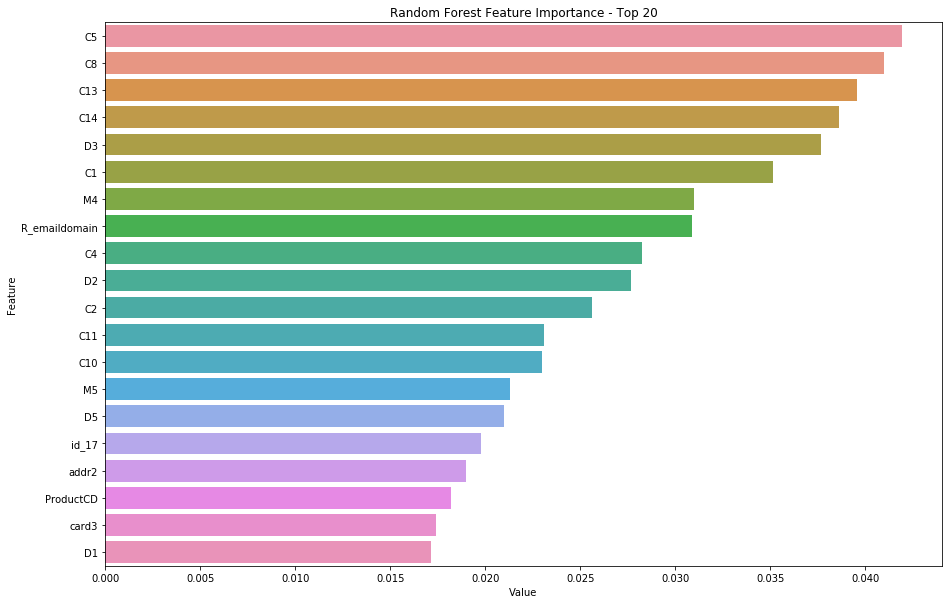

In [60]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
plt.title('Random Forest Feature Importance - Top 20')
plt.show()

In [61]:
n_frauds  = len(y_proba[y_proba > 0.90])

print('Predicted {} frauds.'.format(n_frauds))

Predicted 1099 frauds.


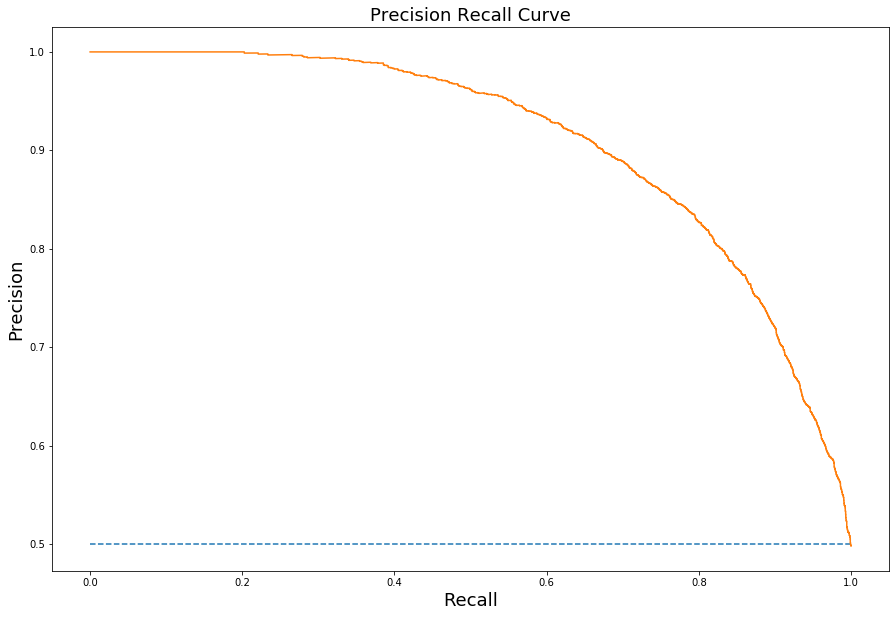

In [62]:
from sklearn import metrics

precision_c, recall_c, thresholds = metrics.precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(15, 10))
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall_c, precision_c)
plt.title("Precision Recall Curve", fontsize=18)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

plt.show()

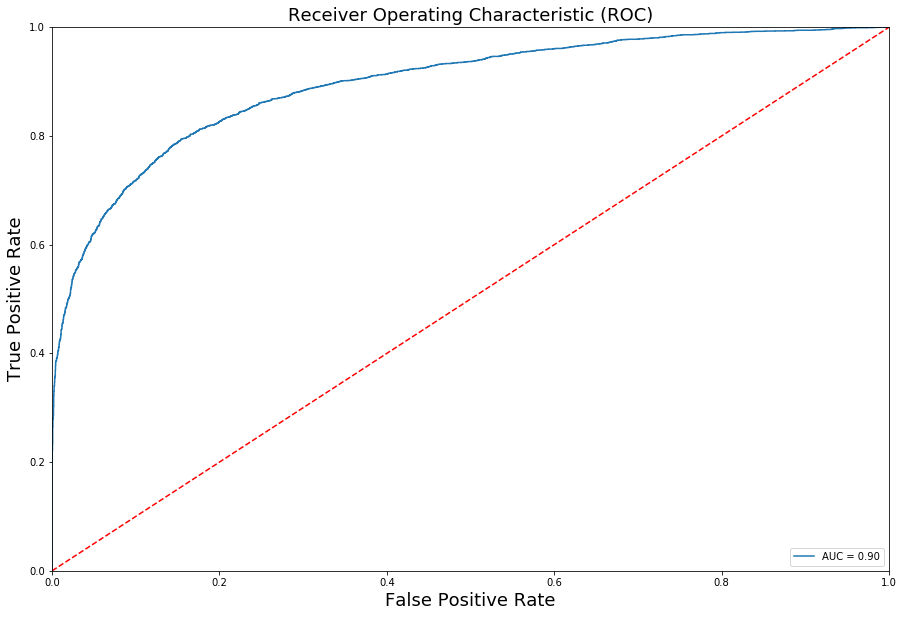

In [63]:
from sklearn import metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(15, 10))
plt.title('Receiver Operating Characteristic (ROC)', fontsize=18)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.show();

In [0]:
scores['RandomForest'] = [accuracy, f1score, precision, recall, mse, n_frauds]

result_roc['RandomForest'] = [fpr, tpr, roc_auc]

## XGB


In [0]:
from sklearn import preprocessing
import xgboost as xgb

In [0]:
clf = xgb.XGBClassifier(n_estimators=500,
                        max_depth=9,
                        learning_rate=0.05,
                        subsample=0.7,
                        colsample_bytree=0.7,
                        missing=-999, 
                        tree_method='gpu_hist')

In [67]:
%%time

clf.fit(X_train, y_train)

CPU times: user 6.35 s, sys: 1.1 s, total: 7.45 s
Wall time: 7.76 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-999, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, tree_method='gpu_hist', verbosity=1)

In [0]:
y_preds = clf.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_preds)

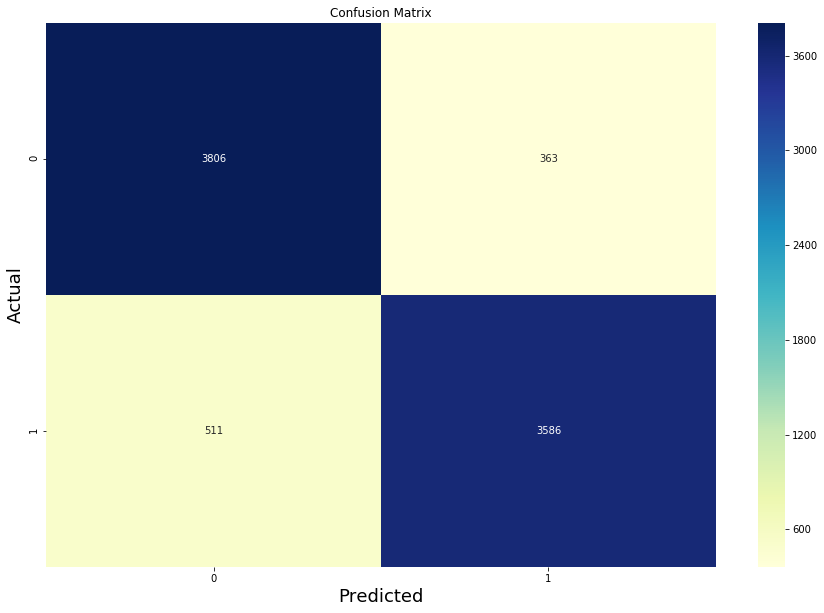

In [70]:
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True,  fmt="d", cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.show()

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_preds)
f1score = f1_score(y_test, y_preds, average='weighted', pos_label='1')
precision = precision_score(y_test, y_preds, average='weighted', pos_label='1')
recall= recall_score(y_test, y_preds, average='weighted', pos_label='1')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

Accuracy:  0.894265666586015
Precision:  0.8947391955461163
Recall:  0.894265666586015


In [0]:
y_proba = clf.predict_proba(X_test)[:,1]

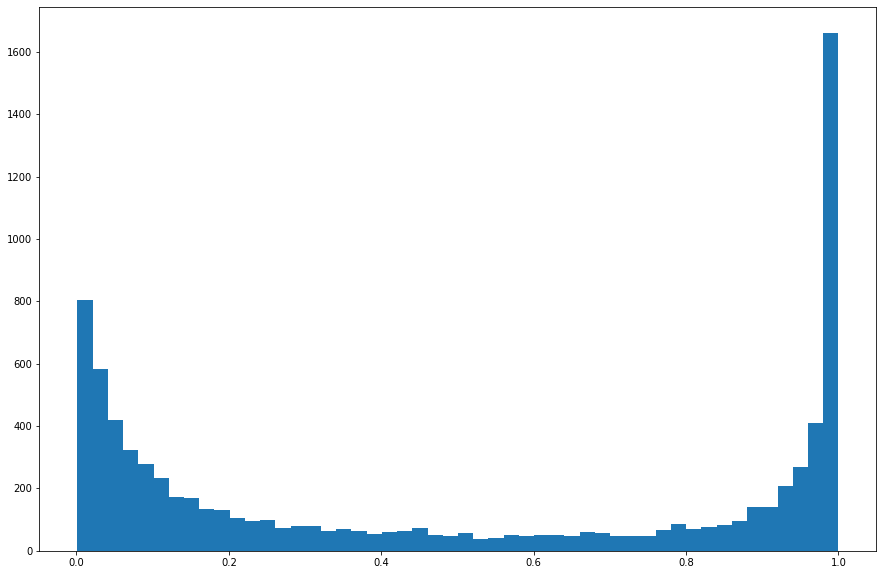

In [73]:
plt.figure(figsize=(15, 10))
plt.hist(y_proba, bins=50);

In [74]:
from sklearn.metrics import mean_squared_error 

mse = mean_squared_error(y_test, y_proba)
mse

0.0785381426193039

In [75]:
# Top 20 Feature importance

feature_important = clf.get_booster().get_score(importance_type="weight")

data = pd.DataFrame(data=feature_important.values(), 
                    index=feature_important.keys(), 
                    columns=["score"]).sort_values(by = "score", ascending=False)

# Top 20 features
data.head(20)

,score
card1,3899
TransactionID,3627
card2,3392
addr1,2941
card1_TransactionAmt_std,2583
DT_day,2272
D15,2066
card2_TransactionAmt_std,2037
D4,2006
dist1,1890


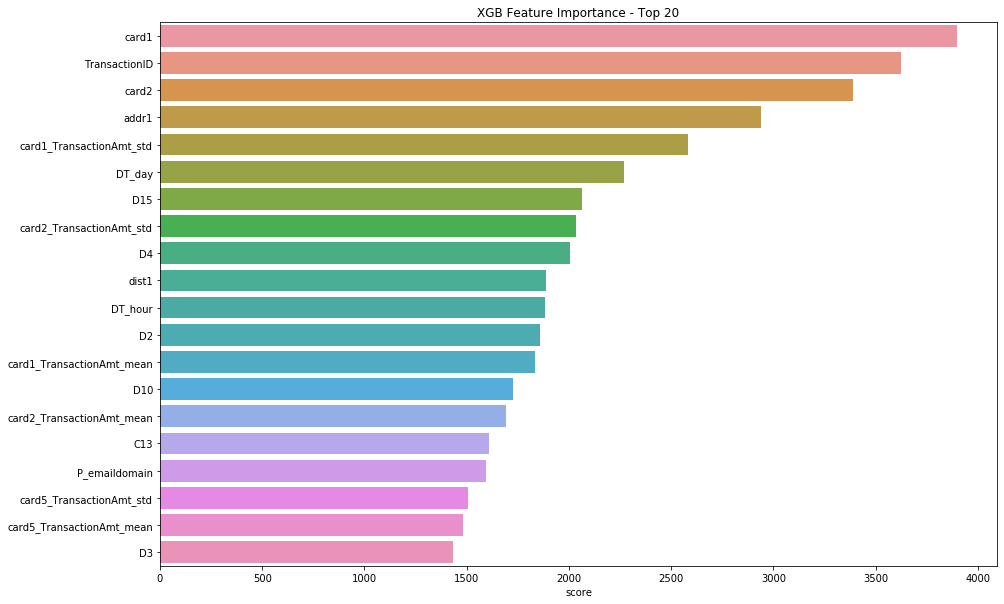

In [76]:
plt.figure(figsize=(15, 10))
sns.barplot(x=data[:20].score, y=data[:20].index, data=data[:20])
plt.title('XGB Feature Importance - Top 20')
plt.show()

In [77]:
n_frauds  = len(y_proba[y_proba > 0.90])

print('Predicted {} frauds.'.format(n_frauds))

Predicted 2685 frauds.


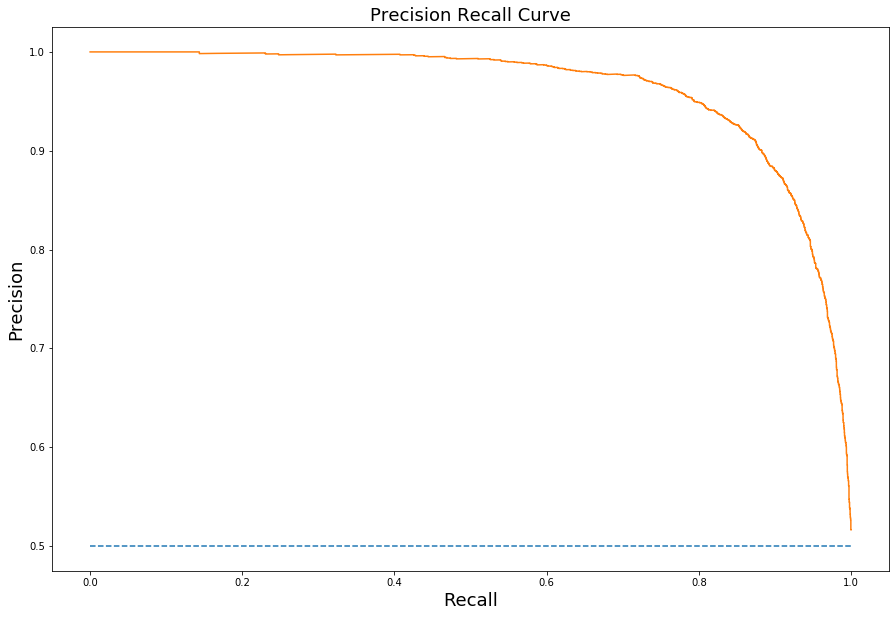

In [78]:
from sklearn import metrics

precision_c, recall_c, thresholds = metrics.precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(15, 10))
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall_c, precision_c)
plt.title("Precision Recall Curve", fontsize=18)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

plt.show()

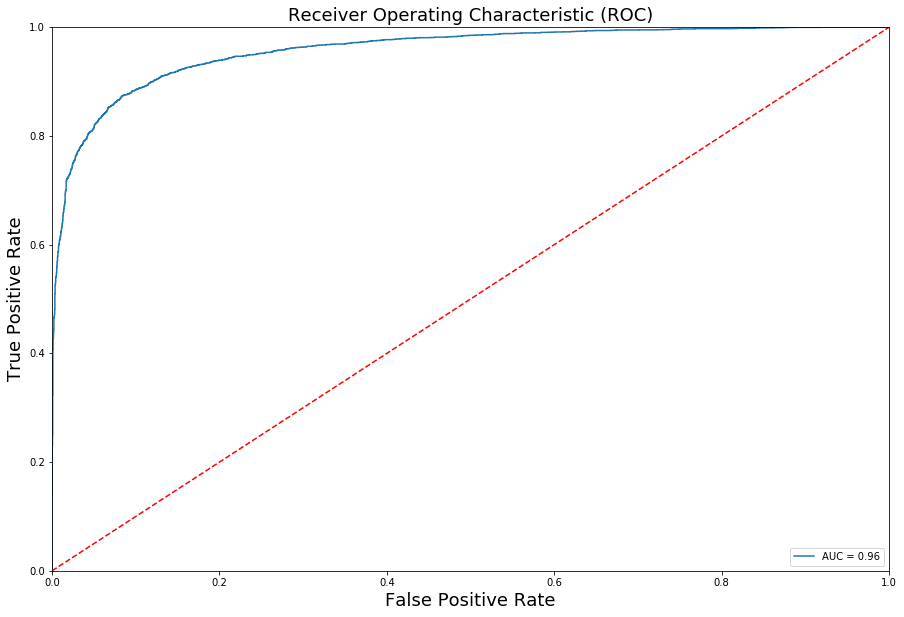

In [79]:
from sklearn import metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(15, 10))
plt.title('Receiver Operating Characteristic (ROC)', fontsize=18)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.show();

In [0]:
scores['XGB'] = [accuracy, f1score, precision, recall, mse, n_frauds]

result_roc['XGB'] = [fpr, tpr, roc_auc]

## LGBM

In [0]:
import lightgbm as lgb

clf = lgb.LGBMClassifier(
    max_bin = 63,
    num_leaves = 255,
    num_iterations = 500,
    learning_rate = 0.01,
    tree_learner = 'serial',
    task = 'train',
    is_training_metric = False,
    min_data_in_leaf = 1,
    min_sum_hessian_in_leaf = 100,
    sparse_threshold=1.0,
    num_thread = -1,
    save_binary= True,
    seed= 42,
    feature_fraction_seed = 42,
    bagging_seed = 42,
    drop_seed = 42,
    data_random_seed = 42,
    objective = 'binary',
    boosting_type = 'gbdt',
    verbose = 1,
    metric = 'auc',
    is_unbalance = True,
    boost_from_average = False,
)

In [82]:
%%time 

clf = clf.fit(X_train, y_train)

CPU times: user 13.7 s, sys: 76.9 ms, total: 13.7 s
Wall time: 13.7 s


In [0]:
y_preds = clf.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_preds)

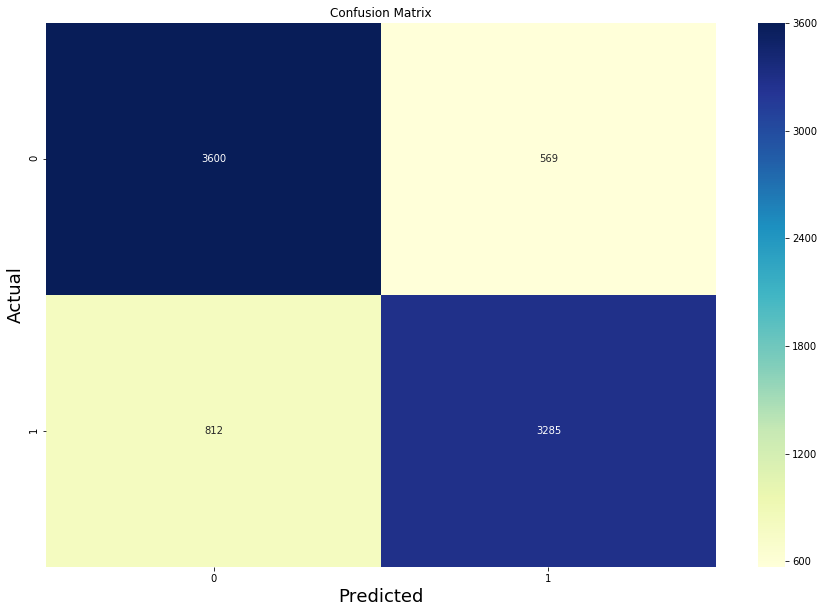

In [85]:
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True,  fmt="d", cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.show()

In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_preds)
f1score = f1_score(y_test, y_preds, average='weighted', pos_label='1')
precision = precision_score(y_test, y_preds, average='weighted', pos_label='1')
recall= recall_score(y_test, y_preds, average='weighted', pos_label='1')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

Accuracy:  0.8329300750060489
Precision:  0.834000283366838
Recall:  0.8329300750060489


In [0]:
y_proba = clf.predict_proba(X_test)[:,1]

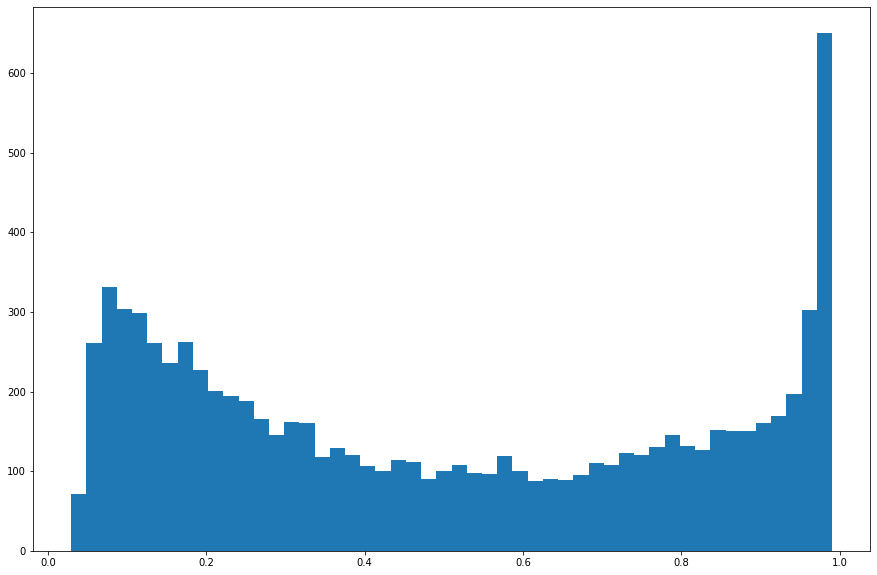

In [88]:
plt.figure(figsize=(15, 10))
plt.hist(y_proba, bins=50);

In [89]:
from sklearn.metrics import mean_squared_error 

mse = mean_squared_error(y_test, y_proba)
mse

0.12199468644868008

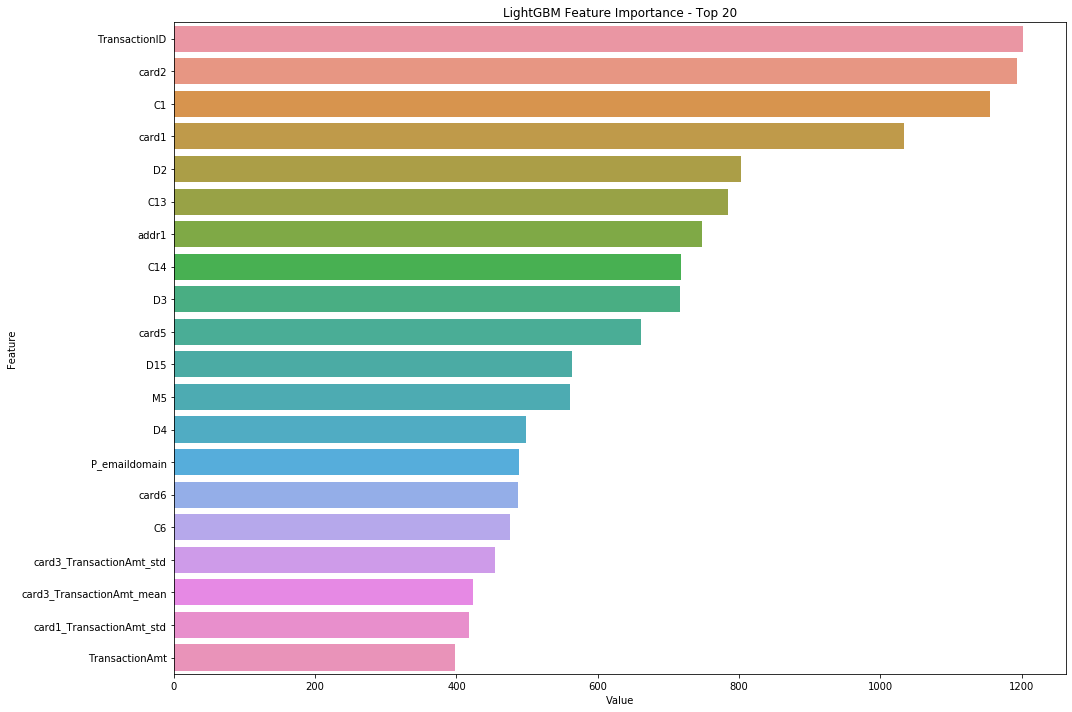

In [90]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
plt.title('LightGBM Feature Importance - Top 20')
plt.tight_layout()
plt.show()

In [91]:
n_frauds  = len(y_proba[y_proba > 0.90])

print('Predicted {} frauds.'.format(n_frauds))

Predicted 1429 frauds.


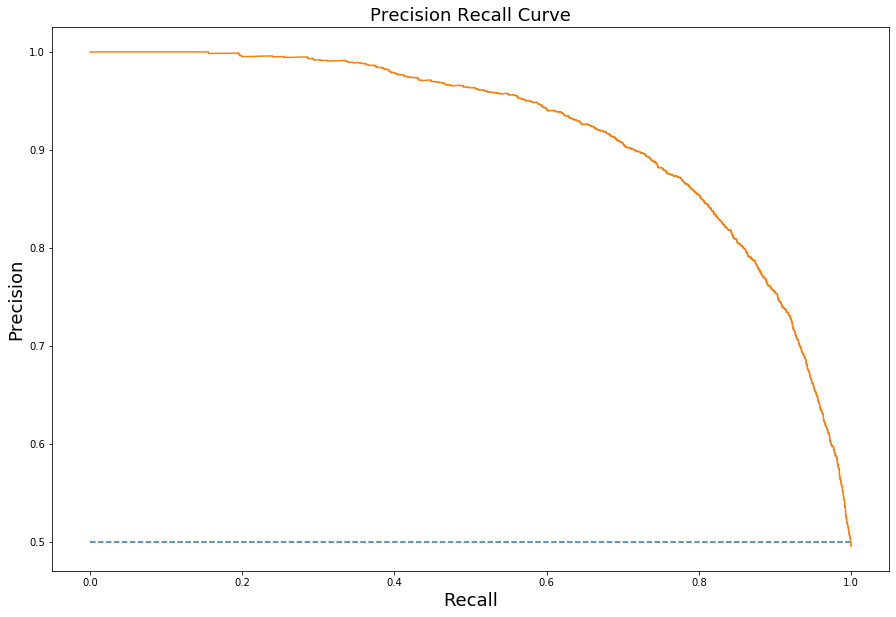

In [92]:
from sklearn import metrics

precision_c, recall_c, thresholds = metrics.precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(15, 10))
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall_c, precision_c)
plt.title("Precision Recall Curve", fontsize=18)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

plt.show()

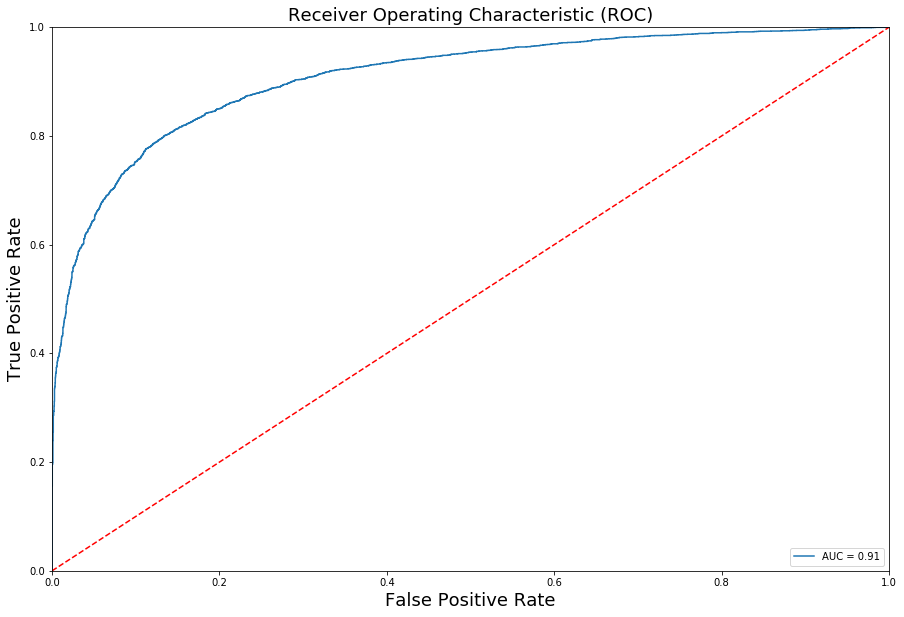

In [93]:
from sklearn import metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(15, 10))
plt.title('Receiver Operating Characteristic (ROC)', fontsize=18)
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.show();

In [0]:
scores['LGBM'] = [accuracy, f1score, precision, recall, mse, n_frauds]

result_roc['LGBM'] = [fpr, tpr, roc_auc]

## Results

In [95]:
pd.DataFrame.from_dict(scores, orient='index', columns=['Accuracy', 'F1 Score', 'Precision', 'Recall', 'Mean Squared Error', 'Number of Frauds Predicted'])

,Accuracy,F1 Score,Precision,Recall,Mean Squared Error,Number of Frauds Predicted
LogisticRegression,0.694169,0.691620,0.699719,0.694169,0.199193,492
RandomForest,0.817445,0.816987,0.819994,0.817445,0.135561,1099
XGB,0.894266,0.894215,0.894739,0.894266,0.078538,2685
LGBM,0.832930,0.832743,0.834000,0.832930,0.121995,1429


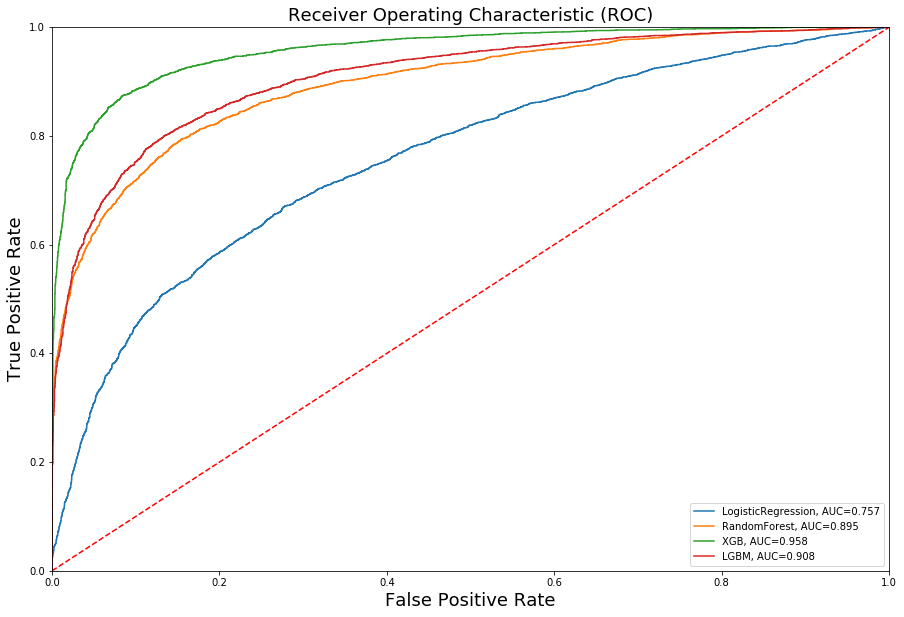

In [96]:
from sklearn import metrics

plt.figure(figsize=(15, 10))
plt.title('Receiver Operating Characteristic (ROC)', fontsize=18)

for k in result_roc.keys():
    plt.plot(result_roc[k][0], 
             result_roc[k][1], 
             label="{}, AUC={:.3f}".format(k, result_roc[k][2]))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.show();

# References

* https://towardsdatascience.com/detecting-financial-fraud-using-machine-learning-three-ways-of-winning-the-war-against-imbalanced-a03f8815cce9
* https://towardsdatascience.com/credit-card-fraud-detection-a1c7e1b75f59
* https://towardsdatascience.com/detecting-credit-card-fraud-using-machine-learning-a3d83423d3b8
* https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda
* https://www.kaggle.com/jesucristo/fraud-complete-eda
* https://www.kaggle.com/artgor/eda-and-models
* https://www.kaggle.com/shahules/tackling-class-imbalance
* https://www.kaggle.com/sundaramoorthyks/eda-feature-engineering
* https://www.kaggle.com/pavelvpster/ieee-fraud-eda-lightgbm-baseline#EDA,-feature-engineering,-LightGBM-baseline
* https://www.kaggle.com/suoires1/fraud-detection-eda-and-modeling